# Swin Unet

- Model implematation: https://medium.com/@ashishbisht0307/swin-transformer-based-unet-architecture-for-semantic-segmentation-with-pytorch-code-91e779334e8e
- Paper: https://arxiv.org/abs/2105.05537


In [13]:
%pip install einops timm imutils torchvision lightning torchmetrics

You should consider upgrading via the '/Users/haily/.pyenv/versions/3.10.4/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
try:
    from utils import get_seg_lightning_modules, get_segmentation_plot, local_paths, kaggle_paths
except Exception as e:
    import sys
    sys.path.append("/kaggle/input/segmentation-util")
    from utils import get_seg_lightning_modules, get_segmentation_plot, local_paths, kaggle_paths


In [15]:
FAST = False # Fast dev: run 1 batch only
LOCAL = True
ACCELERATOR = 'mps'

dataset_paths = local_paths if LOCAL else kaggle_paths

## Swin Unet Model


In [16]:
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision
from torch.utils.data import TensorDataset
import math


def window_partition(x, window_size):
    # print('window_size: ', window_size)
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0],
               W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous(
    ).view(-1, window_size[0], window_size[1], C)
    return windows


def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W //
                     window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x


def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(
        win_h), torch.arange(win_w), indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - \
        coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(
        1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww


class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim = dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) ** 2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(
            self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(
            B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N,
                             N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x


class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size=8, shift_size=0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear(4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            # nW, window_size, window_size, 1
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(
                attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        # nW*B, window_size, window_size, C
        x_windows = window_partition(shifted_x, self.window_size)
        # nW*B, window_size*window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)

        # W-MSA/SW-MSA
        # nW*B, window_size*window_size, C
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = attn_windows.view(-1,
                                         self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(
            attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H, W, C)
        return x


class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, num_feat, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, num_feat, kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0, 2, 3, 1)


class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0,
                                                          1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H, W, 2, 2, C//4)
        x = x.permute(0, 1, 3, 2, 4, 5)

        x = x.reshape(B, H*2, W*2, C//4)

        x = self.norm(x)
        return x


class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H, W, 4, 4, C//16)
        x = x.permute(0, 1, 3, 2, 4, 5)

        x = x.reshape(B, H*4, W*4, C//16)

        x = self.norm(x)
        return x


class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size=3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(
            dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H, W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block, patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H, W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand, swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features, self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size), num_blocks)
        self.bottleneck = SwinBlock(
            C*(2**num_blocks), (H//(patch_size * (2**num_blocks)), W//(patch_size * (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size), num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head = nn.Conv2d(C, num_class, 1, padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x, skip_ftrs = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0, 3, 1, 2))

        return x

## Shenzhen


In [17]:
s_dm, s_module, s_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['shenzen'],
    model_name='shenzen_swinunet',
    model=SwinUNet(512, 512, 3, 32, 2),
    fast=FAST,
    accelerator=ACCELERATOR
)

s_trainer.fit(s_module, s_dm)
s_trainer.test(s_module, s_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: logs/shenzen_swinunet

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SwinUNet         | 3.1 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.219    Total estimated model params size (MB)


318 examples in the training set...
106 examples in the validation set...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 159/159 [01:56<00:00,  1.36it/s, v_num=0, train_loss=0.220, val_loss=0.145] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 159/159 [01:57<00:00,  1.36it/s, v_num=0, train_loss=0.220, val_loss=0.145]
142 examples in the test set...


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 71/71 [00:12<00:00,  5.46it/s]
f1: 0.9589403725006211
accuracy: 0.9397133572000853
precision: 0.969650968699388
recall: 0.9491074983502777
mean_iou: 0.9147535109184157


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.17002220451831818    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.17002220451831818}]

142 examples in the test set...
tensor([0, 1])
Epoch 0:   0%|          | 0/1 [42:10<?, ?it/s]
tensor([0, 1])
tensor([0, 1])


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

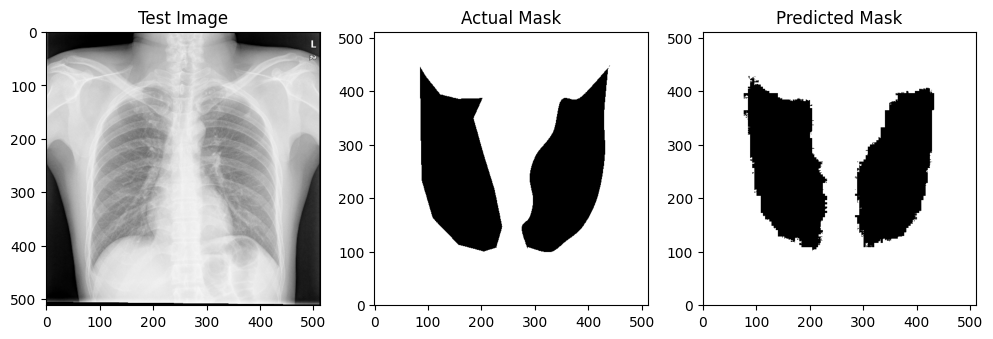

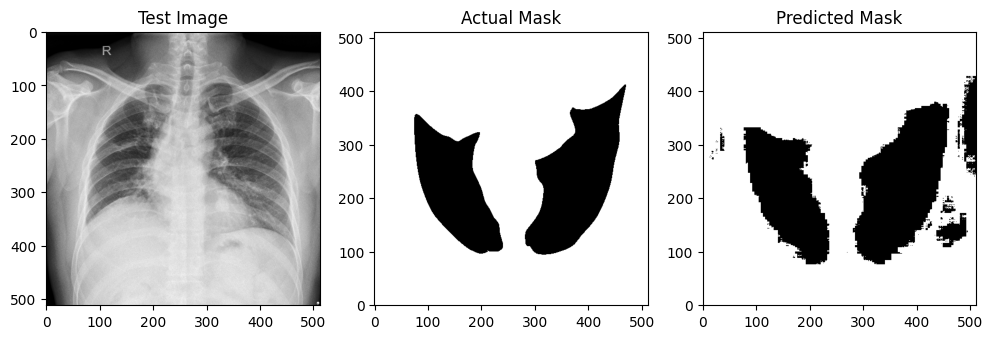

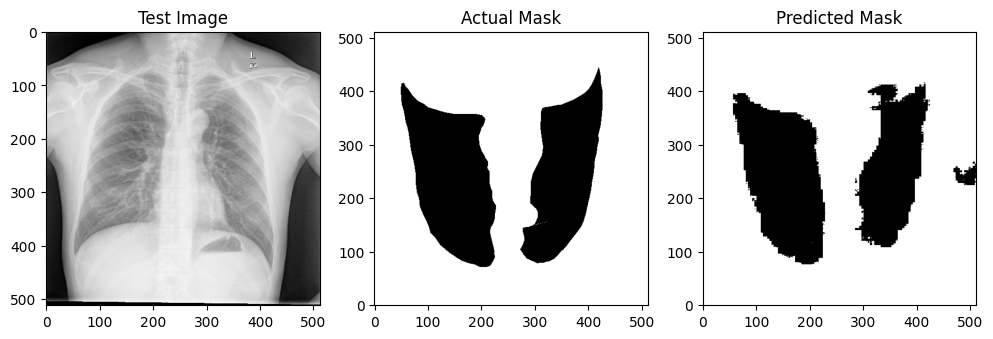

In [18]:
s_dm.setup('test')
get_segmentation_plot(
    s_module.model, 
    s_dm.test, 
    device='cpu')

## Darwin


In [19]:
d_dm, d_module, d_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['darwin'],
    model_name='darwin_swinunet',
    model=SwinUNet(512, 512, 3, 32, 2),
    fast=FAST,
    accelerator=ACCELERATOR
)

d_trainer.fit(d_module, d_dm)
d_trainer.test(d_module, d_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: logs/darwin_swinunet

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SwinUNet         | 3.1 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.219    Total estimated model params size (MB)


3434 examples in the training set...
1145 examples in the validation set...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1:  47%|████▋     | 812/1717 [07:02<07:50,  1.92it/s, v_num=0, train_loss=0.343, val_loss=0.466] 

/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


1527 examples in the test set...
Testing: |          | 0/? [00:00<?, ?it/s]

1527 examples in the test set...
tensor([0, 1])
tensor([0, 1])
tensor([0, 1])


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

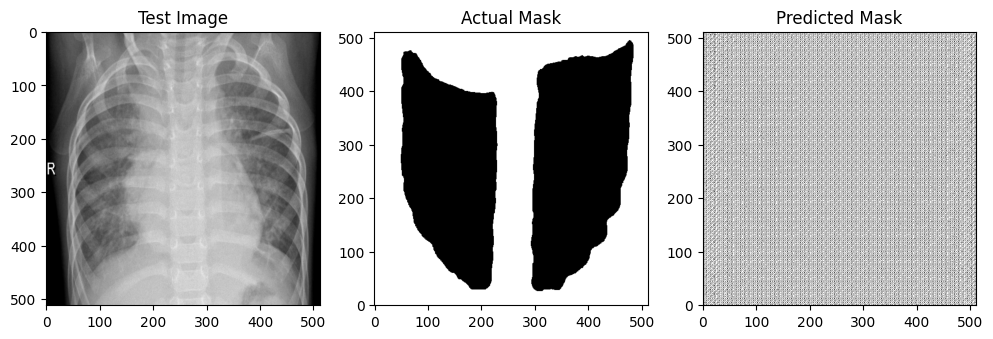

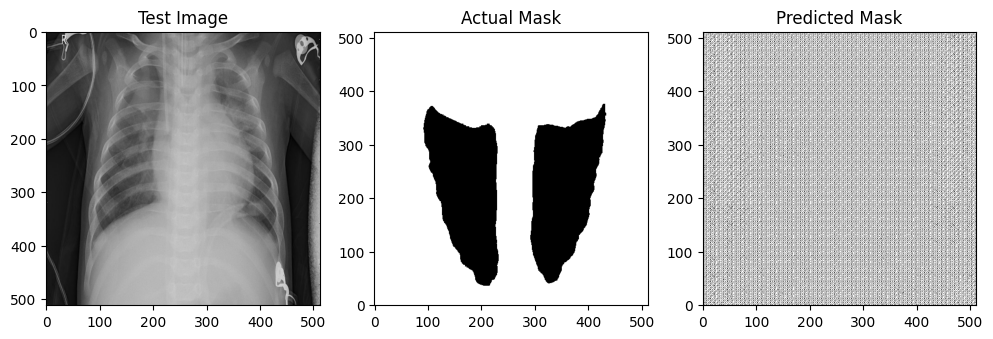

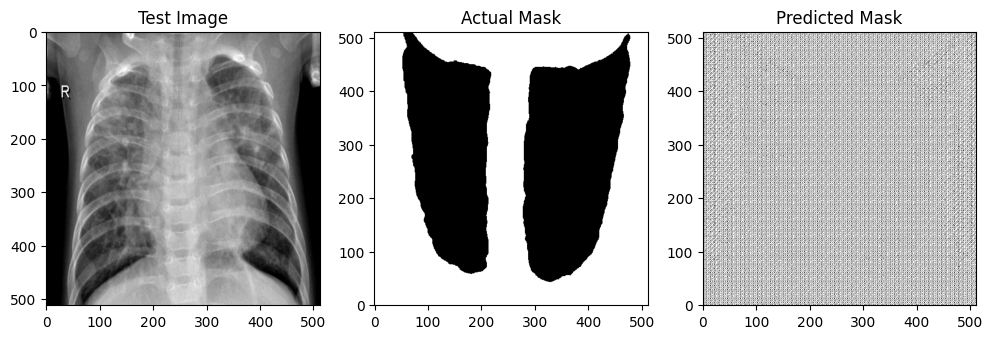

In [ ]:
d_dm.setup('test')
get_segmentation_plot(
    d_module.model,
    d_dm.test,
    device='cpu'
)

## Covid


In [ ]:
c_dm, c_module, c_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['covid'],
    model_name='covid_swinunet',
    model=SwinUNet(256, 256, 3, 32, 2),
    fast=FAST,
    accelerator=ACCELERATOR
)
c_trainer.fit(c_module, c_dm)
c_trainer.test(c_module, c_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SwinUNet         | 3.1 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.219    Total estimated model params size (MB)


2034 examples in the training set...
678 examples in the validation set...
Epoch 0: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, train_loss=0.830, val_loss=0.690]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, train_loss=0.830, val_loss=0.690]
904 examples in the test set...


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]
f1: 0.699383556842804
accuracy: 0.5762100219726562
precision: 0.7620232701301575
recall: 0.6462598443031311
mean_iou: 0.527076244354248


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6755099296569824     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6755099296569824}]

904 examples in the test set...
tensor([0, 1])
tensor([0, 1])
tensor([0, 1])


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

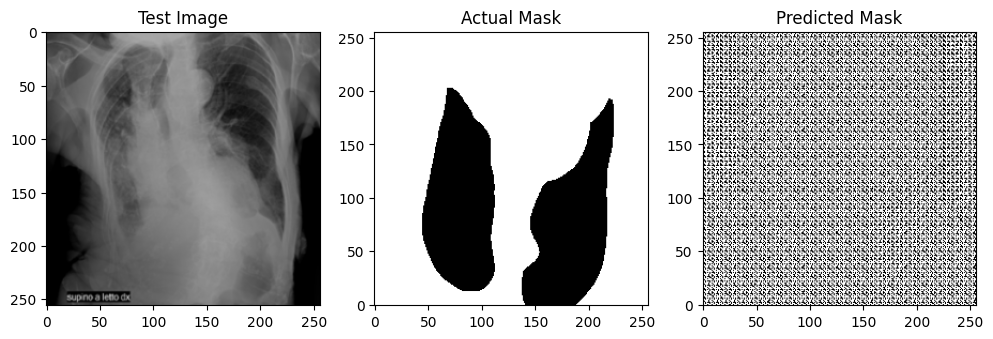

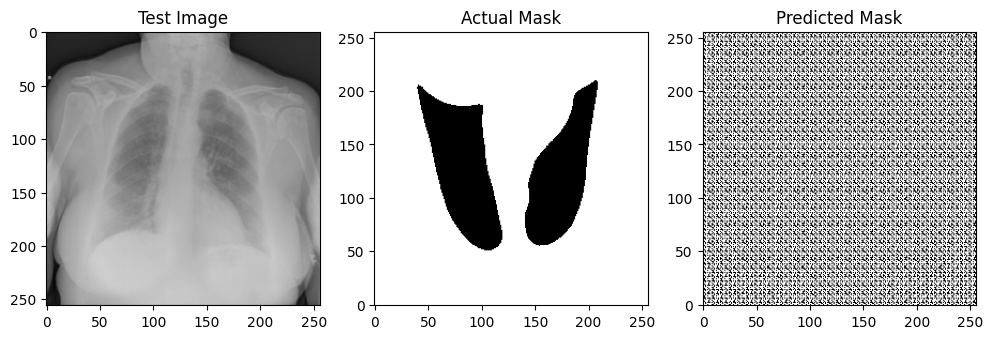

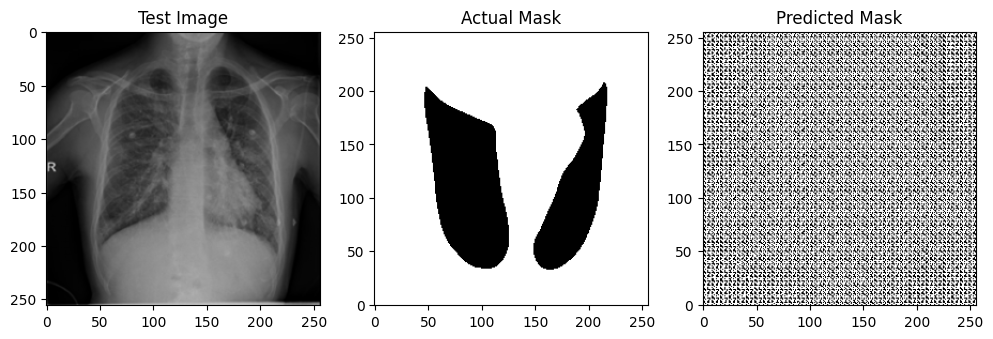

In [ ]:
c_dm.setup('test')
get_segmentation_plot(
    c_module.model, 
    c_dm.test, 
    device='cpu')